# Liscense Plate Detection with WPOD-NET

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# from utils import detect_lp
from os.path import splitext,basename
from utils import detect_lp

import tensorflow as tf
import keras
from keras.models import model_from_json
import glob

In [2]:
def load_model(model_path, model_weights):
    '''
    Input (STR): path to model.json, model.h5
    reads the model path, get model architecture from .json then load
    the weights from .h5 
    '''
    try:
        # parse json string to initialize model instance       
        with open(model_path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects=None)
        # load model weights
        model.load_weights(model_weights)
        print('Loaded model successfully...')
        
        return model
    except Exception as e:
        print(e)
        
        

In [3]:
wpod_net = load_model('wpod-net.json', 'wpod-net.h5')
# wpod_net.summary()

Loaded model successfully...


## Pre-process inputs

In [4]:
def preprocess(img_path, resize=False):
    '''
    Input: (STR) image path, (Bool) resize
    Output: processed version of image
    '''
    im = cv2.imread(img_path)
    # convert to RGB
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    # standardize pixels between 0 and 1     
    im = im / 255
    # resize: if dim not (224,224)    
    if resize:
        im = cv2.resize(im, (224,224))
    return im

## Code to license plate detection

## Should a batch of input images

Found 526 images...


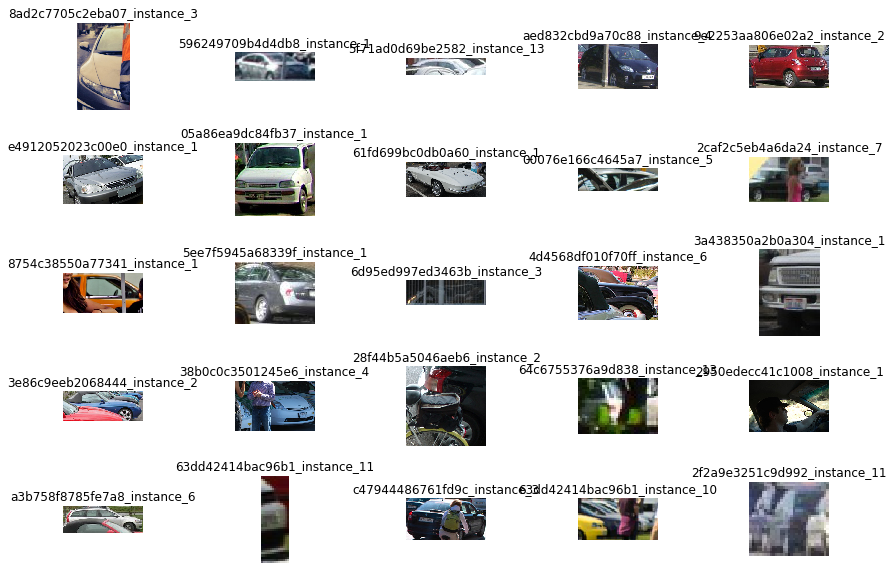

In [5]:
# Get list of .jpg files in car_bbox_out
input_path = glob.glob('car_bbox_out/*.jpg')
print('Found %i images...'%(len(input_path)))

# Visualize images with plot
fig = plt.figure(figsize=(12,8))
cols = 5
rows = 5
fig_list = []

for i in range(cols*rows):
    fig_list.append(fig.add_subplot(rows,cols,i+1))
    title = splitext(basename(input_path[i]))[0]
    fig_list[-1].set_title(title)
    img = preprocess(input_path[i])
    plt.axis(False)
    plt.imshow(img)
plt.tight_layout(True)
plt.show()

(69, 111)

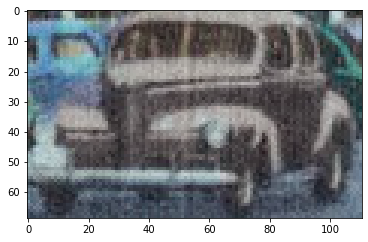

In [14]:
im = cv2.imread(input_path[487])
plt.imshow(im)
im.shape[:2]


##  Detected license plate on one image

Detect 2 plate(s) in ab64e828b7787162_instance_1
Coordinate of plate(s) in image: 
 [array([[777.36952207, 839.48641641, 836.1337479 , 774.01685357],
       [309.65144024, 293.97912225, 336.3767833 , 352.0491013 ],
       [  1.        ,   1.        ,   1.        ,   1.        ]]), array([[785.97799978, 854.29407769, 861.47695201, 793.16087409],
       [270.23884505, 258.91626603, 285.26875804, 296.59133705],
       [  1.        ,   1.        ,   1.        ,   1.        ]])]


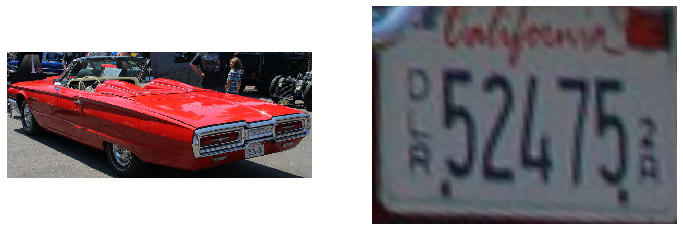

In [23]:
def detect_plate(img_path):
    '''
    Input: img_path (STR)
    This function calculates the Resizing-Factor mentioned in the paper
    Dmin = 288 and Dmax = 608 are chosen such that it produces optimal
        results between accuracy and running time
    '''
    Dmax = 608
    Dmin = 288
    bbox = preprocess(img_path)
    # get width:height image ratio     
    ratio = float(max(bbox.shape[:2]) / min(bbox.shape[:2]))
    size = int(ratio*Dmin)
    bound = min(size, Dmax)
    # Detect LP with wpod-net
    try:
        _ , LpImg, _, cor = detect_lp(wpod_net, bbox, bound, lp_threshold=0.5)
        return LpImg, cor
    except TypeError:
        print('No LP detected, return None')
        return None, None
        

# 34, 270 has detectable plate
# 56
demo = input_path[270]
LpImg, cor = detect_plate(demo)


if LpImg:
    print("Detect %i plate(s) in"%len(LpImg),splitext(basename(demo))[0])
    print("Coordinate of plate(s) in image: \n", cor)

    # Visualize our result
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.axis(False)
    plt.imshow(preprocess(demo))
    plt.subplot(1,2,2)
    plt.axis(False)
    plt.imshow(LpImg[0])
else:
    demo_img = cv2.imread(demo)
    plt.imshow(demo_img)



## Script taken online to draw bounding box around LP

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Before np conversion:  <class 'list'> [[58, 120], [101, 111], [99, 125], [57, 134]]
After np conversion:  <class 'numpy.ndarray'> [[ 58 120]
 [101 111]
 [ 99 125]
 [ 57 134]]


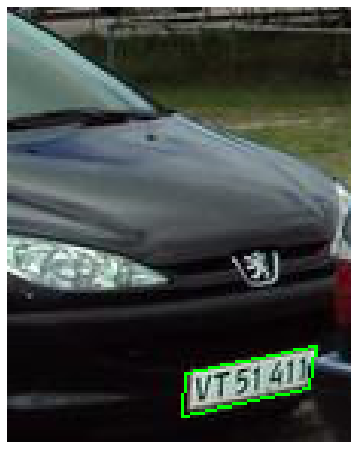

In [30]:
def draw_box(image_path, cor, thickness=1):
    '''
    Get coordinates from detect_plate() and draw a bounding box on 
    the input image
    NOTE: each indices in cor is a LP instance, the 0th index is the
    instance with highest prob to be a LP
    '''
    pts=[]
    
    # try to plot second_pts to see the mis-prediction     
    second_pts=[]
    
    x_coordinates=cor[0][0]
    y_coordinates=cor[0][1]
    
    dummy_x = cor[1][0]
    dummy_y = cor[1][1]
    # store the top-left, top-right, bottom-left, bottom-right 
    # of the plate license respectively
    for i in range(4):
        pts.append([int(x_coordinates[i]),int(y_coordinates[i])])
        
        # this is only to see the other predicted LP instances                   
        second_pts.append([int(dummy_x[i]), int(dummy_y[i])])
    '''
    Need to change list to type(mp.array) but not sure why reshape
    is necessary - without reshaping, the function also works?    
    '''
    print('Before np conversion: ', type(pts), pts)
    # convert to np.array and reshape         
    pts = np.array(pts, np.int32)
    second_pts = np.array(second_pts, np.int32)
    print('After np conversion: ', type(pts), pts)
#     pts = pts.reshape((-1,1,2))
#     print('After reshape: ', pts)
    vehicle_image = preprocess(image_path)
    
    cv2.polylines(vehicle_image,[pts],True,(0,255,0),thickness)
    return vehicle_image

plt.figure(figsize=(8,8))
plt.axis(False)
plt.imshow(draw_box(demo,cor))

## Run WPOD-NET on a few images and visualize LP output

(reconstruct) No LP detected:  list index out of range
(detect_lp) Caught TypeError:  'NoneType' object is not iterable
No LP detected, return None
(reconstruct) No LP detected:  list index out of range
(detect_lp) Caught TypeError:  'NoneType' object is not iterable
No LP detected, return None
(reconstruct) No LP detected:  list index out of range
(detect_lp) Caught TypeError:  'NoneType' object is not iterable
No LP detected, return None
(reconstruct) No LP detected:  list index out of range
(detect_lp) Caught TypeError:  'NoneType' object is not iterable
No LP detected, return None
(reconstruct) No LP detected:  list index out of range
(detect_lp) Caught TypeError:  'NoneType' object is not iterable
No LP detected, return None
(reconstruct) No LP detected:  list index out of range
(detect_lp) Caught TypeError:  'NoneType' object is not iterable
No LP detected, return None
(reconstruct) No LP detected:  list index out of range
(detect_lp) Caught TypeError:  'NoneType' object is not i

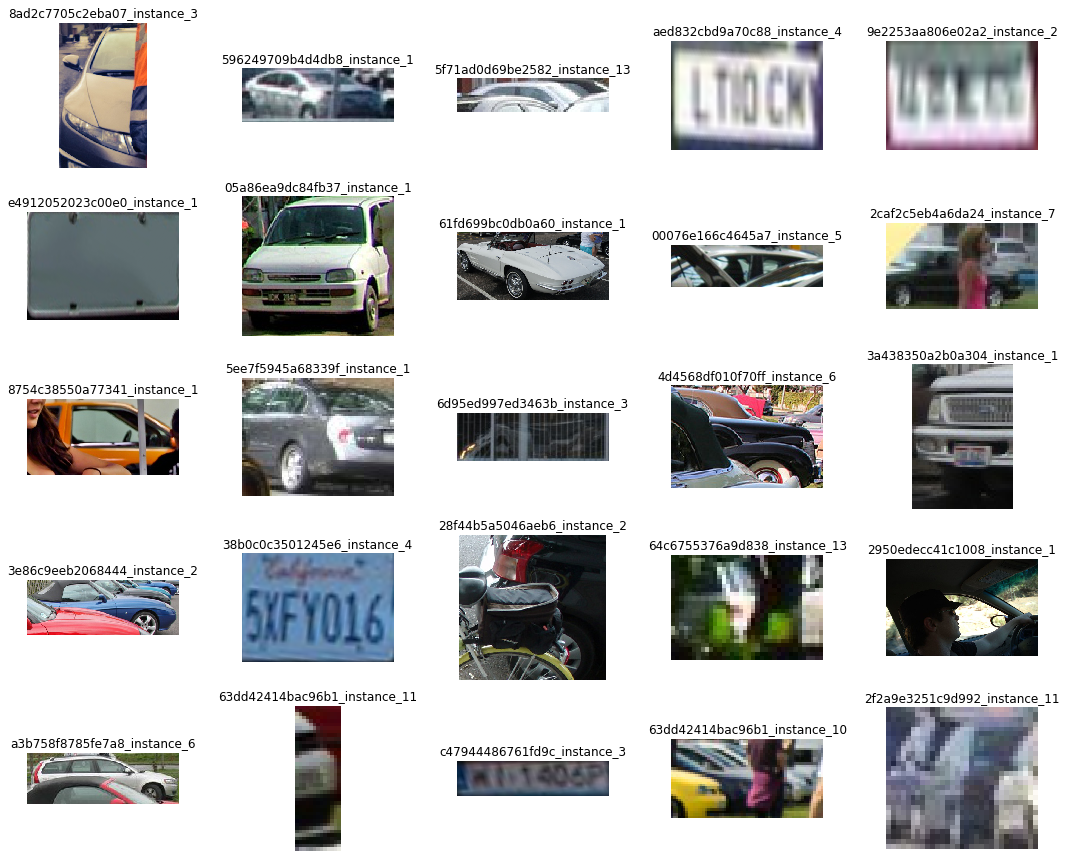

In [29]:
# Run WPOD-NET on several images from input_path and plot the 
# detected LP

# Visualize images with plot
fig = plt.figure(figsize=(15,12))
cols = 5
rows = 5
fig_list = []

for i in range(cols*rows):
    fig_list.append(fig.add_subplot(rows,cols,i+1))
    title = splitext(basename(input_path[i]))[0]
    fig_list[-1].set_title(title)
    
    # Instead of preprocess the image, run wpod-net
    img = preprocess(input_path[i])
    LpImg, _ = detect_plate(input_path[i])
    
    try:
        plt.axis(False)
        plt.imshow(LpImg[0])
        
    # Catch error when no LP is detected     
    except TypeError:
        plt.axis(False)
        plt.imshow(img)
    
plt.tight_layout(True)
plt.savefig('lp_detect_subset.png')
plt.show()
